## Submission by:
1. Aman (MDS202305)
2. Ankan Kar (MCS202303)
3. Utpalraj Kemprai (MDS202352)

## Downloading the Emotion Detection Dataset

In [ ]:
# Download the Emotion Detection Dataset from Kaggle
!kaggle datasets download -d ananthu017/emotion-detection-fer

# Unzip the dataset
!unzip emotion-detection-fer.zip -d emotion_detection_dataset

Streaming output truncated to the last 5000 lines.
  inflating: emotion_detection_dataset/train/sad/im37.png  
  inflating: emotion_detection_dataset/train/sad/im370.png  
  inflating: emotion_detection_dataset/train/sad/im3700.png  
  inflating: emotion_detection_dataset/train/sad/im3701.png  
  inflating: emotion_detection_dataset/train/sad/im3702.png  
  inflating: emotion_detection_dataset/train/sad/im3703.png  
  inflating: emotion_detection_dataset/train/sad/im3704.png  
  inflating: emotion_detection_dataset/train/sad/im3705.png  
  inflating: emotion_detection_dataset/train/sad/im3706.png  
  inflating: emotion_detection_dataset/train/sad/im3707.png  
  inflating: emotion_detection_dataset/train/sad/im3708.png  
  inflating: emotion_detection_dataset/train/sad/im3709.png  
  inflating: emotion_detection_dataset/train/sad/im371.png  
  inflating: emotion_detection_dataset/train/sad/im3710.png  
  inflating: emotion_detection_dataset/train/sad/im3711.png  
  inflating: emotion_de

## Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
import torch.optim as optim
from PIL import Image
import os
import numpy, random
import matplotlib.pyplot as plt

torch.manual_seed(14)
random.seed(14)
numpy.random.seed(14)

# this 'device' will be used for training our model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Loading the train and test data from the Emotion Detection Dataset

In [ ]:
class EmotionDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.emotion_map = {
            "angry": 0,
            "disgusted": 1,
            "fearful": 2,
            "happy": 3,
            "neutral": 4,
            "sad": 5,
            "surprised": 6,
        }

        for emotion_dir in os.listdir(root_dir):
            emotion_path = os.path.join(root_dir, emotion_dir)
            if os.path.isdir(emotion_path):
                for image_name in os.listdir(emotion_path):
                    image_path = os.path.join(emotion_path, image_name)
                    self.image_paths.append(image_path)
                    self.labels.append(self.emotion_map[emotion_dir])


    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path)
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

## Defining transformations for training and test data

In [ ]:
# Define transformations for training and testing
train_transform = transforms.Compose([
    # Resize the image to 224x224 pixels
    transforms.Resize((224, 224)),
    # Convert grayscale image to 3-channel RGB by duplicating the grayscale channel
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    # Normalize the image using mean and std for ImageNet-trained ResNet
    # ImageNet mean and std for RGB: mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    # Resize the image to 224x224 pixels
    transforms.Resize((224, 224)),
    # Convert grayscale image to 3-channel RGB by duplicating the grayscale channel
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    # Normalize the image using mean and std for ImageNet-trained ResNet
    # ImageNet mean and std for RGB: mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [ ]:
# Create datasets
train_dataset = EmotionDataset(root_dir="emotion_detection_dataset/train", transform=train_transform)
test_dataset = EmotionDataset(root_dir="emotion_detection_dataset/test", transform=test_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
print(f"Training data size: {len(train_loader.dataset)}")
print(f"Test data size: {len(test_loader.dataset)}")

Training data size: 28709
Test data size: 7178


## Visualizing some images from the dataset

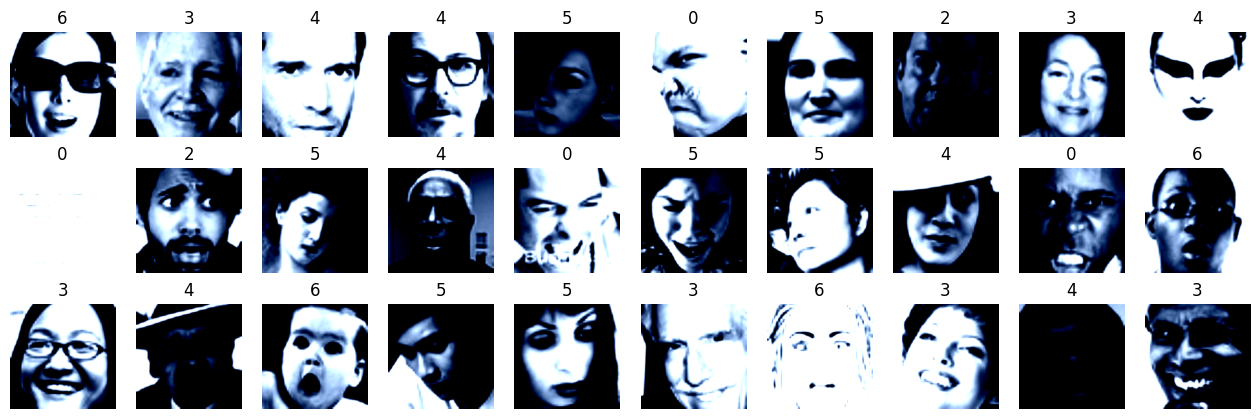

In [ ]:
# show some training images
plt.figure(figsize=(16, 5))

# fetch a batch of train images; RANDOM
image_batch, label_batch = next(iter(train_loader))

for i in range(30):
    image = image_batch[i]
    label = label_batch[i].item()
    plt.subplot(3, 10, i + 1)
    #image, label = train_loader.dataset.__getitem__(i)
    plt.imshow(numpy.transpose(numpy.clip(image,0.0,1.0),(1, 2, 0)))
    plt.axis('off')
    plt.title(label)

## Helper Functions for training and testing


In [ ]:
# function to count number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

accuracy_list = []
# we pass a model object to this trainer, and it trains this model for one epoch
def train(epoch, model):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # send to device
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        #loss = F.nll_loss(output, target)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # send to device
        data, target = data.to(device), target.to(device)

        output = model(data)
        #test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
        test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

## Creating a Resnet-18 Classifier from scratch

In [ ]:
resnet = models.resnet18(weights = None)

# Modify the final layer for number of classes
num_classes = 7
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)

## Training the Resnet-18 model built from scratch

In [ ]:
print("Training on ", device)
resnet = resnet.to(device)
optimizer = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)
print('Number of parameters: {}'.format(get_n_params(resnet)))

for epoch in range(30):
    train(epoch, resnet)
    test(resnet)

Training on  cuda:0
Number of parameters: 11180103
Train Epoch: 0 [0/28709 (0%)]	Loss: 1.943082
Train Epoch: 0 [6400/28709 (22%)]	Loss: 1.716654
Train Epoch: 0 [12800/28709 (45%)]	Loss: 1.667034
Train Epoch: 0 [19200/28709 (67%)]	Loss: 1.761961
Train Epoch: 0 [25600/28709 (89%)]	Loss: 1.809642

Test set: Average loss: 1.7646, Accuracy: 1956/7178 (27.25%)

Train Epoch: 1 [0/28709 (0%)]	Loss: 1.963579
Train Epoch: 1 [6400/28709 (22%)]	Loss: 1.699451
Train Epoch: 1 [12800/28709 (45%)]	Loss: 1.726271
Train Epoch: 1 [19200/28709 (67%)]	Loss: 1.704485
Train Epoch: 1 [25600/28709 (89%)]	Loss: 1.690526

Test set: Average loss: 1.7126, Accuracy: 2242/7178 (31.23%)

Train Epoch: 2 [0/28709 (0%)]	Loss: 1.616545
Train Epoch: 2 [6400/28709 (22%)]	Loss: 1.714620
Train Epoch: 2 [12800/28709 (45%)]	Loss: 1.703402
Train Epoch: 2 [19200/28709 (67%)]	Loss: 1.717236
Train Epoch: 2 [25600/28709 (89%)]	Loss: 1.709408

Test set: Average loss: 1.6334, Accuracy: 2475/7178 (34.48%)

Train Epoch: 3 [0/28709 (0%)

## Finetuning a pretrained Resnet-18 model for the dataset

In [ ]:
# Load the pretrained ResNet-18 model
model = models.resnet18(weights = models.ResNet18_Weights.DEFAULT)

# Modify the final layer for number of classes
num_classes = 7
model.fc = nn.Linear(model.fc.in_features, num_classes)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 104MB/s]


In [ ]:
# Freeze all layers except the final one
for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True

# Unfreeze layer4 and the fully connected layer
for param in model.layer4.parameters():
    param.requires_grad = True

# Now the model is ready for training on your new dataset

## Training the pretrained Resnet-18 Model

In [ ]:
print("Training on ", device)
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
print('Number of trainable parameters: {}'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)))
for epoch in range(30):
    train(epoch, model)
    test(model)

Training on  cuda:0
Number of trainable parameters: 8397319
Train Epoch: 0 [0/28709 (0%)]	Loss: 2.161059
Train Epoch: 0 [6400/28709 (22%)]	Loss: 1.627867
Train Epoch: 0 [12800/28709 (45%)]	Loss: 1.349217
Train Epoch: 0 [19200/28709 (67%)]	Loss: 1.380808
Train Epoch: 0 [25600/28709 (89%)]	Loss: 1.227409

Test set: Average loss: 1.2605, Accuracy: 3771/7178 (52.54%)

Train Epoch: 1 [0/28709 (0%)]	Loss: 1.061363
Train Epoch: 1 [6400/28709 (22%)]	Loss: 1.270546
Train Epoch: 1 [12800/28709 (45%)]	Loss: 1.113090
Train Epoch: 1 [19200/28709 (67%)]	Loss: 0.900299
Train Epoch: 1 [25600/28709 (89%)]	Loss: 0.996175

Test set: Average loss: 1.1563, Accuracy: 4020/7178 (56.00%)

Train Epoch: 2 [0/28709 (0%)]	Loss: 1.139985
Train Epoch: 2 [6400/28709 (22%)]	Loss: 0.845329
Train Epoch: 2 [12800/28709 (45%)]	Loss: 1.055063
Train Epoch: 2 [19200/28709 (67%)]	Loss: 1.207854
Train Epoch: 2 [25600/28709 (89%)]	Loss: 0.897899

Test set: Average loss: 1.1173, Accuracy: 4143/7178 (57.72%)

Train Epoch: 3 [0/2